In [14]:
# package and data importing

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from linearmodels.panel import PanelOLS

wri_df = pd.read_excel('PS_WRI_data_nonlag_TRIMMED.xlsx')

In [22]:
# building our data for panel format application -- WRI specific

# --- Data Preparation ---

# 1. Melt to long format
country_col = [col for col in wri_df.columns if 'country' in col.lower()][0] #Find the country column, case insensitive.


long_data = pd.melt(wri_df,
                    id_vars=[country_col],
                    var_name='year_category',
                    value_name='score')

# 2. Extract year and category - SIMPLIFIED (Correct for consistent format)
long_data[['year', 'category']] = long_data['year_category'].str.split('_', expand=True)
long_data['year'] = long_data['year'].astype(int)

long_data.drop(columns=['year_category'], inplace=True)
long_data.rename(columns={country_col: 'country'}, inplace=True)

# --- Panel Regression ---
long_data = long_data.set_index(['country', 'year'])
regressors = pd.get_dummies(long_data['category'], drop_first=True)
model_fe_panel = PanelOLS(long_data['score'], regressors, entity_effects=True, time_effects=True).fit()

print("Panel Regression Results:")
print(model_fe_panel)
print("\nRobust standard errors:")
print(model_fe_panel.std_errors)

# --- Exporting Results to a Table ---

# 1. Create a dictionary to store the results
results_dict = {
    'Coefficient': model_fe_panel.params,
    'Std. Error': model_fe_panel.std_errors,
    't-statistic': model_fe_panel.tstats,
    'p-value': model_fe_panel.pvalues
}

# 2. Convert the dictionary to a Pandas DataFrame
results_df = pd.DataFrame(results_dict)

# 3. Format the table (optional)
results_df = results_df.round(3)  # Round to 3 decimal places
results_df.index.name = "Variable"  # Set index name

# 4. Export to CSV or other formats
results_df.to_csv('panel_regression_results.csv')  # Export to CSV
# Or export to Excel:
# results_df.to_excel('panel_regression_results.xlsx')
# Or display in a formatted way in your notebook:
print(results_df)

# --- Additional Information (Optional) ---
# You might want to include additional information in your table:

# R-squared
r_squared = model_fe_panel.rsquared
print(f"R-squared: {r_squared:.3f}")

# Number of observations
nobs = model_fe_panel.nobs
print(f"Number of Observations: {nobs}")

# Entity and Time Effects included? - CORRECTED
def effects_status(model_result, effect_type):
    """Checks and returns the status of entity or time effects."""
    try:
        if effect_type == "entity":
            included = model_result.params.index.str.startswith("entity").any()
        elif effect_type == "time":
            included = model_result.params.index.str.startswith("time").any()
        else:
            return "Unknown effect type"
        return "Included" if included else "Not Included"
    except AttributeError:
      return "Not Applicable"

entity_effects_status = effects_status(model_fe_panel, "entity")
time_effects_status = effects_status(model_fe_panel, "time")


# Entity and Time Effects included?
print(f"Entity Effects: {entity_effects_status}")
print(f"Time Effects: {time_effects_status}")

Panel Regression Results:
                          PanelOLS Estimation Summary                           
Dep. Variable:                  score   R-squared:                        0.7637
Estimator:                   PanelOLS   R-squared (Between):             -1.8681
No. Observations:                3000   R-squared (Within):               0.7565
Date:                Mon, Feb 17 2025   R-squared (Overall):             -1.0394
Time:                        22:25:29   Log-likelihood                -1.179e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1907.5
Entities:                          20   P-value                           0.0000
Avg Obs:                       150.00   Distribution:                  F(5,2951)
Min Obs:                       150.00                                           
Max Obs:                       150.00   F-statistic (robust):             1907.5
  

In [ ]:
# Cross-sectional regression approach
import statsmodels.formula.api as smf 

# setting up the year zero data
year_zero_df = pd.read_csv('developmentneeds_GHO2025.csv')
year_zero_df.rename(columns={'country':'country', 'calendar_year':'year'}, inplace=True)
year_zero_df['year'] = year_zero_df['year'].astype(int)

# creating a merged stream
cross_copy = long_data.reset_index()
wri_merged_df = pd.merge(cross_copy, year_zero_df, on= ['country', 'year'], how= 'left')

for country in wri_merged_df['country'].unique():
    # 3. Filter data for the current country and its crisis year:
    country_data = wri_merged_df[wri_merged_df['country'] == country]
    year_of_crisis = country_data['year_of_crisis'].iloc[0] #Get the year of crisis for the country.
    cross_sectional_data = country_data[country_data['year'] == year_of_crisis].copy()

    # 4. Handle Missing Values (Important - same as before, but inside the loop):
    cross_sectional_data.dropna(subset=['people_in_need', 'number_of_refugees', 'number_of_IDPs'], inplace=True)

    # 5. Cross-sectional Regression:
    if not cross_sectional_data.empty:  # Check if there's any data for the country
        model = smf.ols("score ~ people_in_need + number_of_refugees + number_of_IDPs", data=cross_sectional_data).fit()
        print(f"\n--- Results for {country} (Year: {year_of_crisis}) ---")
        print(model.summary())
    else:
        print(f"\n--- No data for {country} in their year of crisis ({year_of_crisis}) ---")

'''
# filtering to target year:
cross_sectional_data = cross_copy[cross_copy['year'] == year_to_analyze].copy()

# aggregating our multiple observations per country
cross_sectional_data = cross_sectional_data.groupby('country')['score'].sum().reset_index()
'''

# --- Cross-Sectional Regression ---
csr_model = smf.ols("score ~ 1", data=cross_sectional_data).fit() #The 1 represents the intercept.

print(csr_model.summary())


In [33]:
print(wri_df.head(4))

                    Country  2000_W  2000_E  2000_V  2000_S  2000_C  2000_A  \
0               Afghanistan    4.19    0.25   70.32   61.91   78.59   71.47   
1              Burkina Faso    1.57    0.07   35.26   60.74   12.92   55.85   
2                  Cameroon   10.58    2.03   55.17   59.12   49.62   57.24   
3  Central African Republic    2.58    0.16   41.69   69.07   15.06   69.66   

   2001_W  2001_E  2001_V  ...  2023_V  2023_S  2023_C  2023_A  2024_W  \
0    4.15    0.25   68.80  ...   64.59   56.02   78.19   61.52    4.12   
1    1.63    0.07   37.82  ...   57.64   47.61   61.45   65.44    2.01   
2    8.54    2.03   35.91  ...   59.74   58.44   61.53   59.29   11.40   
3    3.25    0.16   66.10  ...   70.67   75.77   64.55   72.17    3.44   

   2024_E  2024_V  2024_S  2024_C  2024_A  
0    0.25   67.77   56.66   78.94   69.60  
1    0.07   57.50   59.28   63.22   50.74  
2    2.08   62.44   58.76   65.04   63.69  
3    0.16   73.86   74.75   70.16   76.82  

[4 rows x 15

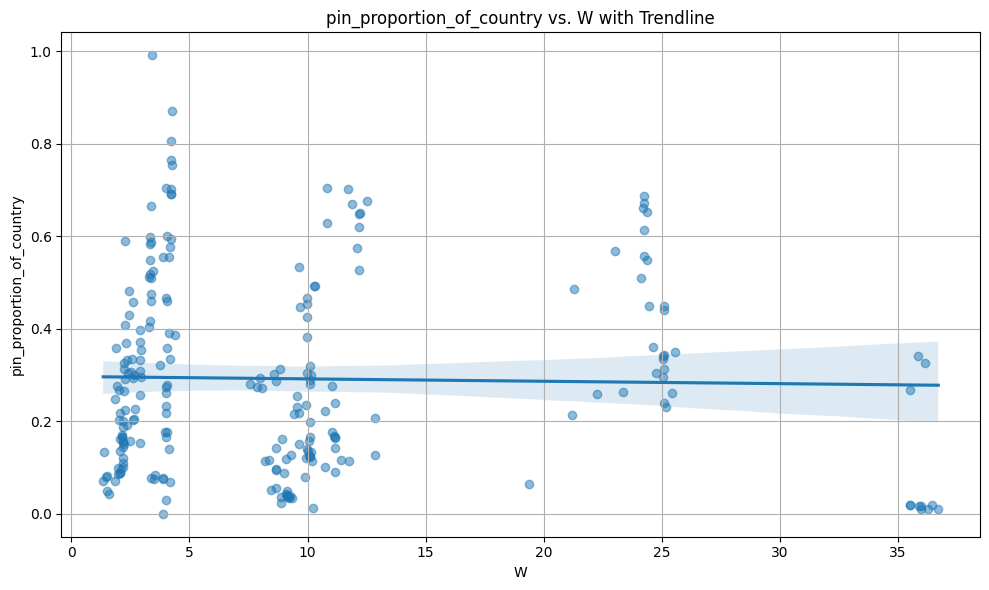

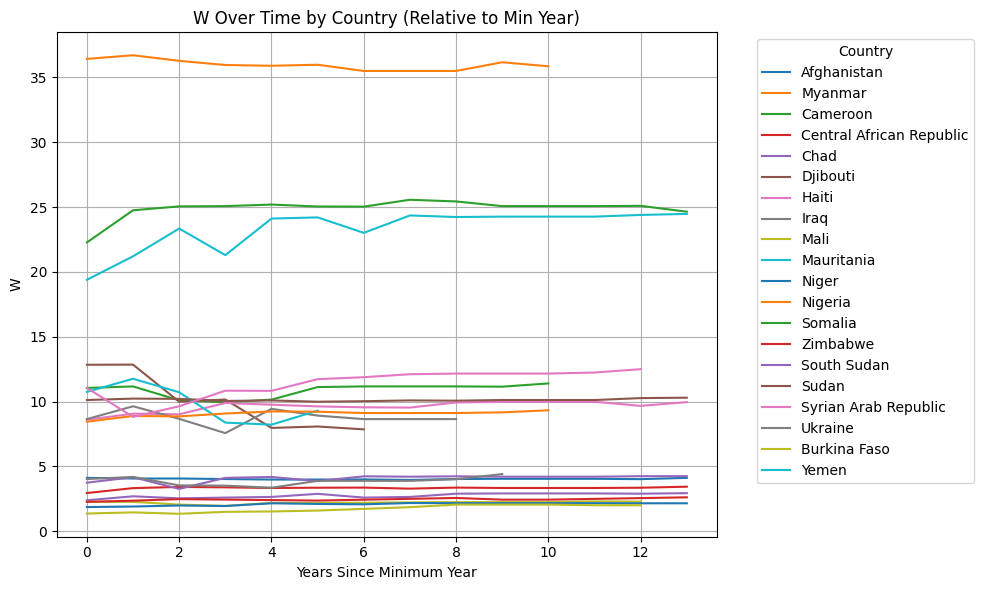


Regression Results (pin_proportion_of_country vs. W):
                                OLS Regression Results                               
Dep. Variable:     pin_proportion_of_country   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                 -0.004
Method:                        Least Squares   F-statistic:                    0.1160
Date:                       Wed, 19 Feb 2025   Prob (F-statistic):              0.734
Time:                               16:03:16   Log-Likelihood:                 37.942
No. Observations:                        236   AIC:                            -71.88
Df Residuals:                            234   BIC:                            -64.96
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [48]:
# converting the R-based approach from Steph
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
ocha = pd.read_csv("GHO 2025 Development Needs.xlsx - Weighted averages.csv")
un_pop = pd.read_excel("Total Population by Sex data_v2.xlsx")
wri_reload_df = pd.read_excel("WRI_maunal_clean_W.xlsx")

# Clean and transform ocha
ocha['people_in_need'] = ocha['people_in_need'].str.replace(",", "").str.strip() # Remove commas and leading/trailing spaces
ocha['people_in_need'] = ocha['people_in_need'].replace(' -   ', np.nan) # Replace "-" with NaN
ocha['numeric_pin'] = pd.to_numeric(ocha['people_in_need'], errors='coerce')
ocha = ocha[["country", "calendar_year", "year_of_crisis", "numeric_pin", "years_since_crisis"]]
ocha['country_year'] = ocha['country'] + ocha['calendar_year'].astype(str)

# Clean and transform un_pop
un_pop['country_year'] = un_pop['Country'] + un_pop['Time'].astype(str)
un_pop['total_country_population'] = pd.to_numeric(un_pop['Value'], errors='coerce') # Handle potential errors in conversion

# Merge ocha and un_pop
merged_ocha_un = pd.merge(un_pop, ocha, on="country_year")
merged_ocha_un = merged_ocha_un[["country_year", "Country", "total_country_population", "calendar_year", "numeric_pin", "years_since_crisis", "year_of_crisis"]]
merged_ocha_un['pin_proportion_of_country'] = merged_ocha_un['numeric_pin'] / merged_ocha_un['total_country_population']
merged_ocha_un = merged_ocha_un.rename(columns={'calendar_year': 'Year'})


# Clean and transform wri_reload_df
wri_reload_df_melted = pd.melt(wri_reload_df, id_vars=['Country'], var_name='Year_Variable', value_name='W') # Only melt for 'W'
wri_reload_df_melted['Year'] = wri_reload_df_melted['Year_Variable'].str[:4].astype(int)
wri_reload_df_melted = wri_reload_df_melted[['Country', 'Year', 'W']] # Keep only necessary columns

# Merge with nd_gain
combined_data = pd.merge(merged_ocha_un, wri_reload_df_melted, on=['Country', 'Year'], how='inner')
combined_data['pin_proportion_of_country'] = combined_data['pin_proportion_of_country'].fillna(0)
combined_data['years_since_min_year'] = combined_data.groupby('Country')['Year'].transform(lambda x: x - x.min())

# --- Analysis ---
# Scatter plot with regression line (Corrected x and y axes)
plt.figure(figsize=(10, 6))
sns.regplot(x='W', y='pin_proportion_of_country', data=combined_data, scatter_kws={'alpha':0.5})  # Corrected order
plt.xlabel("W")  # Corrected label
plt.ylabel("pin_proportion_of_country")  # Corrected label
plt.title("pin_proportion_of_country vs. W with Trendline")  # Corrected title
plt.grid(True)
plt.tight_layout()
plt.show()


# Line plot for each country (using years since min year)
plt.figure(figsize=(10, 6))
for country in combined_data['Country'].unique():
    country_data = combined_data[combined_data['Country'] == country]
    plt.plot(country_data['years_since_min_year'], country_data['W'], label=country)

plt.xlabel("Years Since Minimum Year")
plt.ylabel("W")
plt.title("W Over Time by Country (Relative to Min Year)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Regression - Corrected
X = combined_data['W']  # Independent variable is W
X = sm.add_constant(X)
y = combined_data['pin_proportion_of_country']  # Dependent variable is pin_proportion_of_country
model = sm.OLS(y, X).fit()
print("\nRegression Results (pin_proportion_of_country vs. W):")
print(model.summary())

# Correlation - Corrected
correlation = combined_data['pin_proportion_of_country'].corr(combined_data['W']) 
print(f"Correlation between pin_proportion_of_country and W: {correlation}")

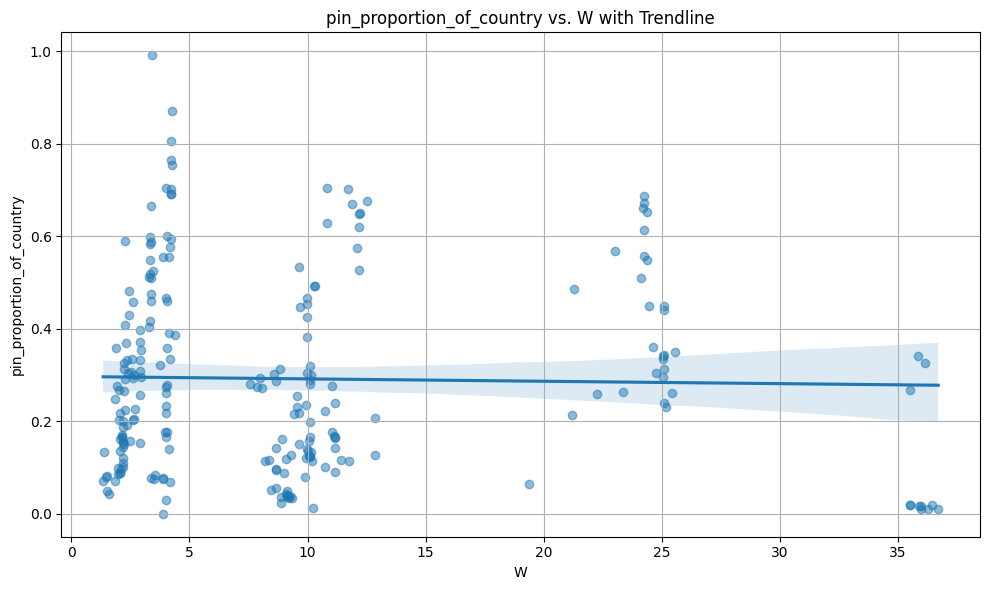

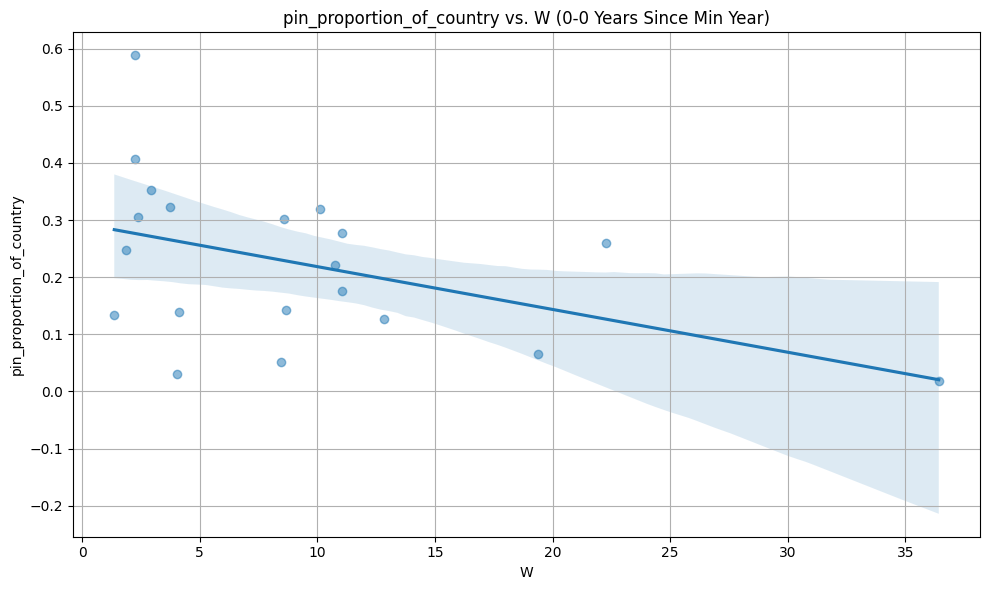


Regression Results (pin_proportion_of_country vs. W (0-0 Years Since Min Year)):
                                OLS Regression Results                               
Dep. Variable:     pin_proportion_of_country   R-squared:                       0.205
Model:                                   OLS   Adj. R-squared:                  0.161
Method:                        Least Squares   F-statistic:                     4.655
Date:                       Wed, 19 Feb 2025   Prob (F-statistic):             0.0447
Time:                               18:03:07   Log-Likelihood:                 13.356
No. Observations:                         20   AIC:                            -22.71
Df Residuals:                             18   BIC:                            -20.72
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|    

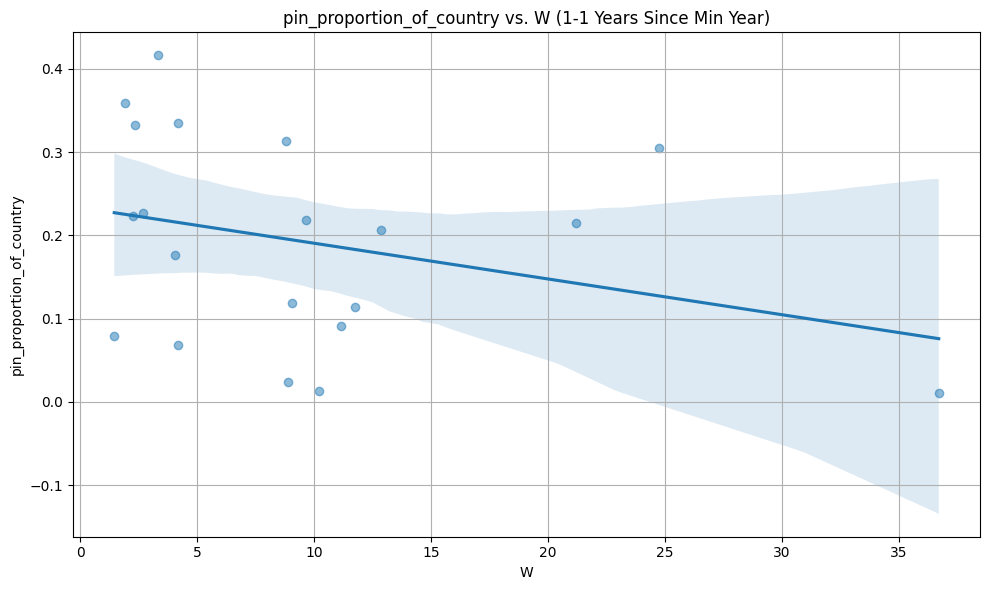


Regression Results (pin_proportion_of_country vs. W (1-1 Years Since Min Year)):
                                OLS Regression Results                               
Dep. Variable:     pin_proportion_of_country   R-squared:                       0.096
Model:                                   OLS   Adj. R-squared:                  0.046
Method:                        Least Squares   F-statistic:                     1.916
Date:                       Wed, 19 Feb 2025   Prob (F-statistic):              0.183
Time:                               18:03:07   Log-Likelihood:                 14.881
No. Observations:                         20   AIC:                            -25.76
Df Residuals:                             18   BIC:                            -23.77
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|    

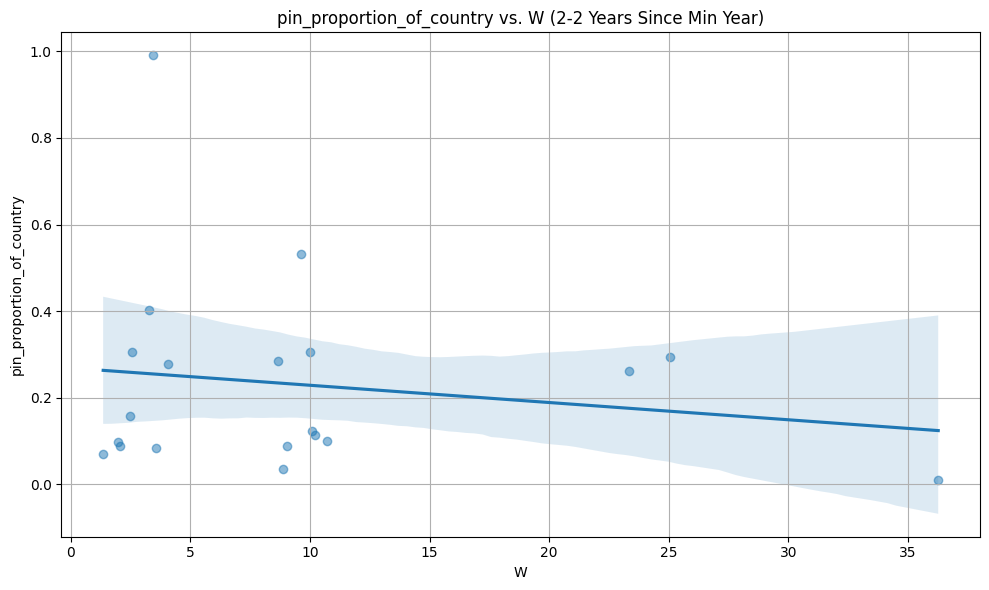


Regression Results (pin_proportion_of_country vs. W (2-2 Years Since Min Year)):
                                OLS Regression Results                               
Dep. Variable:     pin_proportion_of_country   R-squared:                       0.026
Model:                                   OLS   Adj. R-squared:                 -0.028
Method:                        Least Squares   F-statistic:                    0.4798
Date:                       Wed, 19 Feb 2025   Prob (F-statistic):              0.497
Time:                               18:03:07   Log-Likelihood:                 2.2593
No. Observations:                         20   AIC:                           -0.5187
Df Residuals:                             18   BIC:                             1.473
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|    

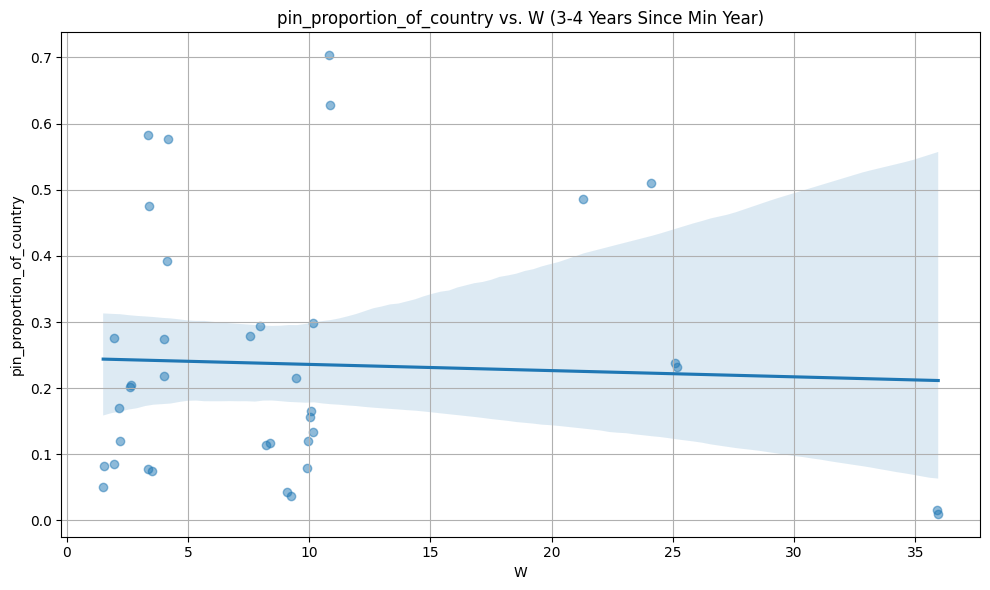


Regression Results (pin_proportion_of_country vs. W (3-4 Years Since Min Year)):
                                OLS Regression Results                               
Dep. Variable:     pin_proportion_of_country   R-squared:                       0.002
Model:                                   OLS   Adj. R-squared:                 -0.026
Method:                        Least Squares   F-statistic:                   0.07292
Date:                       Wed, 19 Feb 2025   Prob (F-statistic):              0.789
Time:                               18:03:07   Log-Likelihood:                 10.103
No. Observations:                         37   AIC:                            -16.21
Df Residuals:                             35   BIC:                            -12.98
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|    

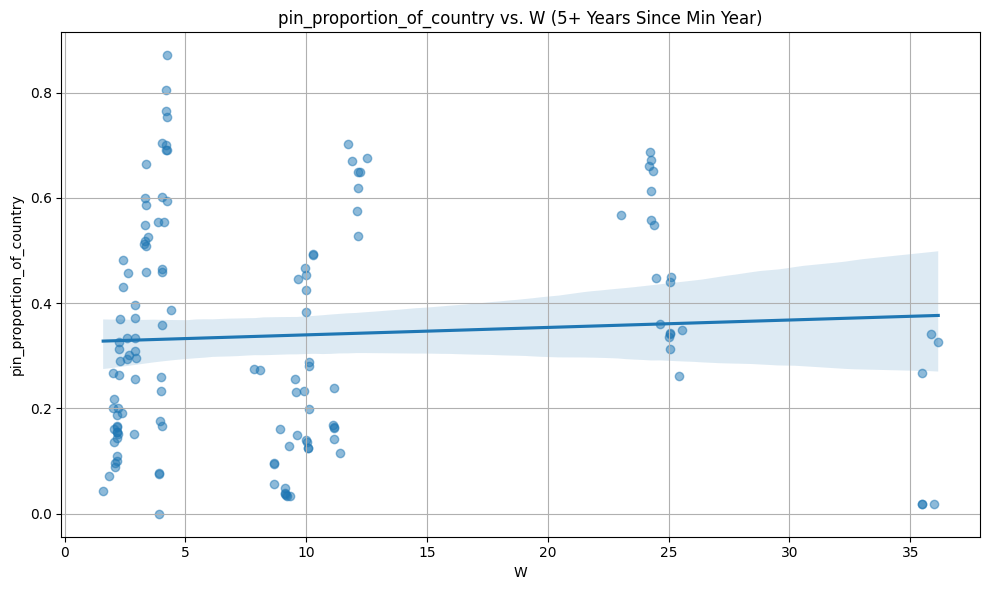


Regression Results (pin_proportion_of_country vs. W (5+ Years Since Min Year)):
                                OLS Regression Results                               
Dep. Variable:     pin_proportion_of_country   R-squared:                       0.004
Model:                                   OLS   Adj. R-squared:                 -0.004
Method:                        Least Squares   F-statistic:                    0.4873
Date:                       Wed, 19 Feb 2025   Prob (F-statistic):              0.486
Time:                               18:03:07   Log-Likelihood:                 17.612
No. Observations:                        139   AIC:                            -31.22
Df Residuals:                            137   BIC:                            -25.36
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|     

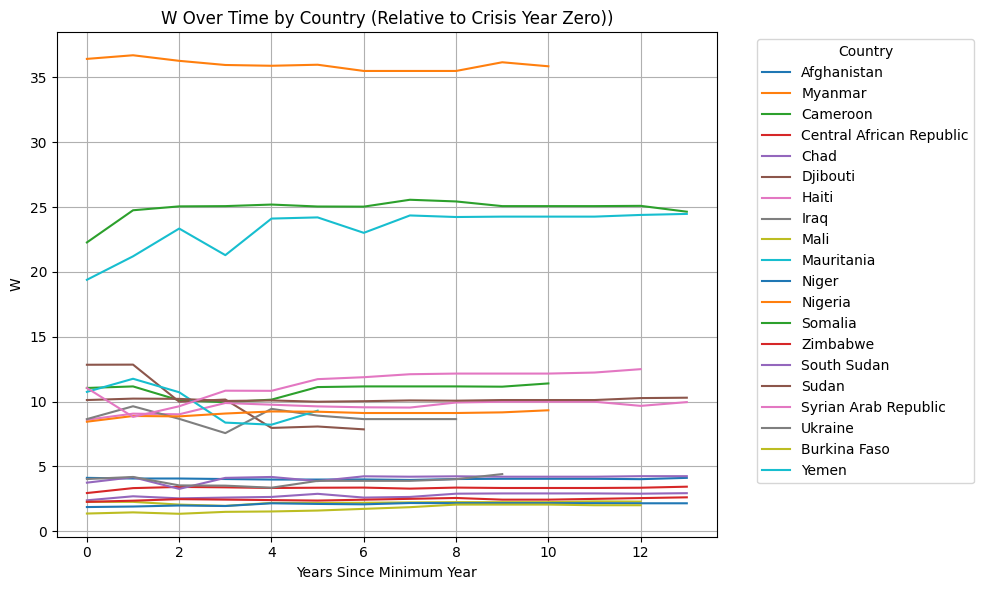


Regression Results (pin_proportion_of_country vs. W):
                                OLS Regression Results                               
Dep. Variable:     pin_proportion_of_country   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                 -0.004
Method:                        Least Squares   F-statistic:                    0.1160
Date:                       Wed, 19 Feb 2025   Prob (F-statistic):              0.734
Time:                               18:03:07   Log-Likelihood:                 37.942
No. Observations:                        236   AIC:                            -71.88
Df Residuals:                            234   BIC:                            -64.96
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [51]:
# time lagged approach -- building on the R-based approach from Steph
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
ocha = pd.read_csv("GHO 2025 Development Needs.xlsx - Weighted averages.csv")
un_pop = pd.read_excel("Total Population by Sex data_v2.xlsx")
wri_reload_df = pd.read_excel("WRI_maunal_clean_W.xlsx")

# Clean and transform ocha
ocha['people_in_need'] = ocha['people_in_need'].str.replace(",", "").str.strip() # Remove commas and leading/trailing spaces
ocha['people_in_need'] = ocha['people_in_need'].replace(' -   ', np.nan) # Replace "-" with NaN
ocha['numeric_pin'] = pd.to_numeric(ocha['people_in_need'], errors='coerce')
ocha = ocha[["country", "calendar_year", "year_of_crisis", "numeric_pin", "years_since_crisis"]]
ocha['country_year'] = ocha['country'] + ocha['calendar_year'].astype(str)

# Clean and transform un_pop
un_pop['country_year'] = un_pop['Country'] + un_pop['Time'].astype(str)
un_pop['total_country_population'] = pd.to_numeric(un_pop['Value'], errors='coerce') # Handle potential errors in conversion

# Merge ocha and un_pop
merged_ocha_un = pd.merge(un_pop, ocha, on="country_year")
merged_ocha_un = merged_ocha_un[["country_year", "Country", "total_country_population", "calendar_year", "numeric_pin", "years_since_crisis", "year_of_crisis"]]
merged_ocha_un['pin_proportion_of_country'] = merged_ocha_un['numeric_pin'] / merged_ocha_un['total_country_population']
merged_ocha_un = merged_ocha_un.rename(columns={'calendar_year': 'Year'})


# Clean and transform wri_reload_df
wri_reload_df_melted = pd.melt(wri_reload_df, id_vars=['Country'], var_name='Year_Variable', value_name='W') # Only melt for 'W'
wri_reload_df_melted['Year'] = wri_reload_df_melted['Year_Variable'].str[:4].astype(int)
wri_reload_df_melted = wri_reload_df_melted[['Country', 'Year', 'W']] # Keep only necessary columns

# Merge with nd_gain
combined_data = pd.merge(merged_ocha_un, wri_reload_df_melted, on=['Country', 'Year'], how='inner')
combined_data['pin_proportion_of_country'] = combined_data['pin_proportion_of_country'].fillna(0)
combined_data['years_since_min_year'] = combined_data.groupby('Country')['Year'].transform(lambda x: x - x.min())

# --- Analysis ---
# Scatter plot with regression line (Corrected x and y axes)
plt.figure(figsize=(10, 6))
sns.regplot(x='W', y='pin_proportion_of_country', data=combined_data, scatter_kws={'alpha':0.5})  # Corrected order
plt.xlabel("W")  # Corrected label
plt.ylabel("pin_proportion_of_country")  # Corrected label
plt.title("pin_proportion_of_country vs. W with Trendline")  # Corrected title
plt.grid(True)
plt.tight_layout()
plt.show()


# Define time periods (adjust as needed)
time_periods = [0, 1, 2, 3, 5] 
for i in range(len(time_periods)):
    start_year = time_periods[i]
    if i < len(time_periods) - 1:
        end_year = time_periods[i+1]
        subset = combined_data[(combined_data['years_since_min_year'] >= start_year) & (combined_data['years_since_min_year'] < end_year)]
        title = f"pin_proportion_of_country vs. W ({start_year}-{end_year-1} Years Since Min Year)"
    else:
        subset = combined_data[combined_data['years_since_min_year'] >= start_year]
        title = f"pin_proportion_of_country vs. W ({start_year}+ Years Since Min Year)"
    
    if len(subset) > 0: # Check if the subset is not empty
        plt.figure(figsize=(10, 6))
        sns.regplot(x='W', y='pin_proportion_of_country', data=subset, scatter_kws={'alpha':0.5})
        plt.xlabel("W")
        plt.ylabel("pin_proportion_of_country")
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Regression for this time period
        X = subset['W']
        X = sm.add_constant(X)
        y = subset['pin_proportion_of_country']
        model = sm.OLS(y, X).fit()
        print(f"\nRegression Results ({title}):")
        print(model.summary())

        # Correlation for this time period
        correlation = subset['pin_proportion_of_country'].corr(subset['W'])
        print(f"Correlation between pin_proportion_of_country and W ({title}): {correlation}")
    else:
        print(f"No data for time period {start_year}+")



# Line plot for each country (using years since min year)
plt.figure(figsize=(10, 6))
for country in combined_data['Country'].unique():
    country_data = combined_data[combined_data['Country'] == country]
    plt.plot(country_data['years_since_min_year'], country_data['W'], label=country)

plt.xlabel("Years Since Minimum Year")
plt.ylabel("W")
plt.title("W Over Time by Country (Relative to Crisis Year Zero))")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Regression - Corrected
X = combined_data['W']  # Independent variable is W
X = sm.add_constant(X)
y = combined_data['pin_proportion_of_country']  # Dependent variable is pin_proportion_of_country
model = sm.OLS(y, X).fit()
print("\nRegression Results (pin_proportion_of_country vs. W):")
print(model.summary())

# Correlation - Corrected
correlation = combined_data['pin_proportion_of_country'].corr(combined_data['W']) 
print(f"Correlation between pin_proportion_of_country and W: {correlation}")